In [ ]:
from google.colab import files
from tensorflow.keras.models import load_model
import cv2
import numpy as np
from tensorflow.keras.preprocessing import image
import zipfile
import os
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
# Langkah 1: Unggah model .h5
print("=== LANGKAH 1: Upload Model CNN ===")
uploaded = files.upload()

# Memuat model yang diunggah
model_path = list(uploaded.keys())[0]  # Mengambil nama file model yang diunggah
model = load_model(model_path)  # Memuat model
print(f"Model berhasil dimuat: {model_path}")

=== LANGKAH 1: Upload Model CNN ===


Saving facial_expression_model.h5 to facial_expression_model.h5


Model berhasil dimuat: facial_expression_model.h5


In [ ]:
# Langkah 2: Unggah file ZIP berisi gambar-gambar
print("\n=== LANGKAH 2: Upload File ZIP Berisi Gambar ===")
uploaded_zip = files.upload()

# Ekstrak file ZIP
zip_path = list(uploaded_zip.keys())[0]
extract_folder = "extracted_images"


=== LANGKAH 2: Upload File ZIP Berisi Gambar ===


Saving sample_photo.zip to sample_photo.zip


In [ ]:
# Buat folder untuk ekstraksi jika belum ada
if not os.path.exists(extract_folder):
    os.makedirs(extract_folder)

# Ekstrak file ZIP
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

print(f"File ZIP berhasil diekstrak ke folder: {extract_folder}")

# Cari semua file gambar dalam folder yang diekstrak
image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.webp']
image_files = []

for root, dirs, files in os.walk(extract_folder):
    for file in files:
        if any(file.lower().endswith(ext) for ext in image_extensions):
            image_files.append(os.path.join(root, file))

print(f"Ditemukan {len(image_files)} gambar untuk diproses")

# Definisi label kelas
class_labels = ['anger', 'contempt', 'disgust', 'fear', 'happy', 'sadness', 'surprise']

# Fungsi untuk memproses satu gambar
def process_single_image(img_path):
    try:
        # Membaca gambar dan mengubah ukurannya menjadi 48x48 (sesuai input model)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        if img is None:
            return None, f"Gagal membaca gambar: {img_path}"

        img_resized = cv2.resize(img, (48, 48))

        # Normalisasi dan reshaping gambar
        img_array = img_resized.astype('float32') / 255.0
        img_array = np.expand_dims(img_array, axis=-1)  # Menambahkan dimensi channel (grayscale)
        img_array = np.expand_dims(img_array, axis=0)  # Menambahkan batch size

        # Prediksi probabilitas untuk setiap kelas
        pred = model.predict(img_array, verbose=0)[0]  # ambil batch pertama

        # Temukan indeks kelas dengan probabilitas tertinggi
        dominant_index = np.argmax(pred)
        dominant_label = class_labels[dominant_index]
        dominant_prob = pred[dominant_index]

        return {
            'predictions': pred,
            'dominant_label': dominant_label,
            'dominant_prob': dominant_prob,
            'image_array': img_resized
        }, None

    except Exception as e:
        return None, f"Error memproses {img_path}: {str(e)}"

File ZIP berhasil diekstrak ke folder: extracted_images
Ditemukan 7 gambar untuk diproses


In [ ]:
# Langkah 3: Proses semua gambar
print(f"\n=== LANGKAH 3: Memproses {len(image_files)} Gambar ===")
results = []

for i, img_path in enumerate(image_files, 1):
    print(f"\nMemproses gambar {i}/{len(image_files)}: {os.path.basename(img_path)}")

    result, error = process_single_image(img_path)

    if error:
        print(f"{error}")
        continue

    # Simpan hasil
    results.append({
        'filename': os.path.basename(img_path),
        'filepath': img_path,
        'result': result
    })

    # Tampilkan hasil untuk gambar ini
    dominant_label = result['dominant_label']
    dominant_prob = result['dominant_prob']

    print(f"Ekspresi Dominan: {dominant_label} ({dominant_prob*100:.2f}%)")

    # Tampilkan probabilitas semua ekspresi
    print("   Probabilitas per ekspresi:")
    for label, probability in zip(class_labels, result['predictions']):
        print(f"   {label}: {probability*100:.2f}%")


=== LANGKAH 3: Memproses 7 Gambar ===

Memproses gambar 1/7: angry.jpg
Ekspresi Dominan: fear (85.42%)
   Probabilitas per ekspresi:
   anger: 0.07%
   contempt: 0.80%
   disgust: 6.28%
   fear: 85.42%
   happy: 2.72%
   sadness: 0.11%
   surprise: 4.59%

Memproses gambar 2/7: surprised.jpg
Ekspresi Dominan: fear (99.96%)
   Probabilitas per ekspresi:
   anger: 0.00%
   contempt: 0.00%
   disgust: 0.00%
   fear: 99.96%
   happy: 0.00%
   sadness: 0.02%
   surprise: 0.02%

Memproses gambar 3/7: sadness.jpg
Ekspresi Dominan: surprise (86.80%)
   Probabilitas per ekspresi:
   anger: 0.46%
   contempt: 0.15%
   disgust: 12.20%
   fear: 0.21%
   happy: 0.03%
   sadness: 0.16%
   surprise: 86.80%

Memproses gambar 4/7: disgust.jpg
Ekspresi Dominan: disgust (93.20%)
   Probabilitas per ekspresi:
   anger: 0.01%
   contempt: 0.03%
   disgust: 93.20%
   fear: 6.25%
   happy: 0.52%
   sadness: 0.00%
   surprise: 0.00%

Memproses gambar 5/7: fear.jpg
Ekspresi Dominan: fear (99.29%)
   Probabilit

In [ ]:
# Langkah 4: Tampilkan ringkasan hasil
print(f"\n=== RINGKASAN HASIL ===")
print(f"Total gambar diproses: {len(results)}")

if results:
    # Hitung distribusi ekspresi dominan
    expression_counts = {}
    for res in results:
        dominant_expr = res['result']['dominant_label']
        expression_counts[dominant_expr] = expression_counts.get(dominant_expr, 0) + 1

    print("\nDistribusi Ekspresi Dominan:")
    for expr, count in sorted(expression_counts.items()):
        percentage = (count / len(results)) * 100
        print(f"  {expr}: {count} gambar ({percentage:.1f}%)")

    # Tampilkan detail setiap gambar
    print(f"\nDetail Hasil Setiap Gambar:")
    for i, res in enumerate(results, 1):
        filename = res['filename']
        dominant_label = res['result']['dominant_label']
        dominant_prob = res['result']['dominant_prob']
        print(f"  {i}. {filename}: {dominant_label} ({dominant_prob*100:.2f}%)")



=== RINGKASAN HASIL ===
Total gambar diproses: 7

Distribusi Ekspresi Dominan:
  contempt: 1 gambar (14.3%)
  disgust: 1 gambar (14.3%)
  fear: 3 gambar (42.9%)
  happy: 1 gambar (14.3%)
  surprise: 1 gambar (14.3%)

Detail Hasil Setiap Gambar:
  1. angry.jpg: fear (85.42%)
  2. surprised.jpg: fear (99.96%)
  3. sadness.jpg: surprise (86.80%)
  4. disgust.jpg: disgust (93.20%)
  5. fear.jpg: fear (99.29%)
  6. happy.png: happy (60.83%)
  7. contempt.jpg: contempt (50.55%)



=== VISUALISASI HASIL ===


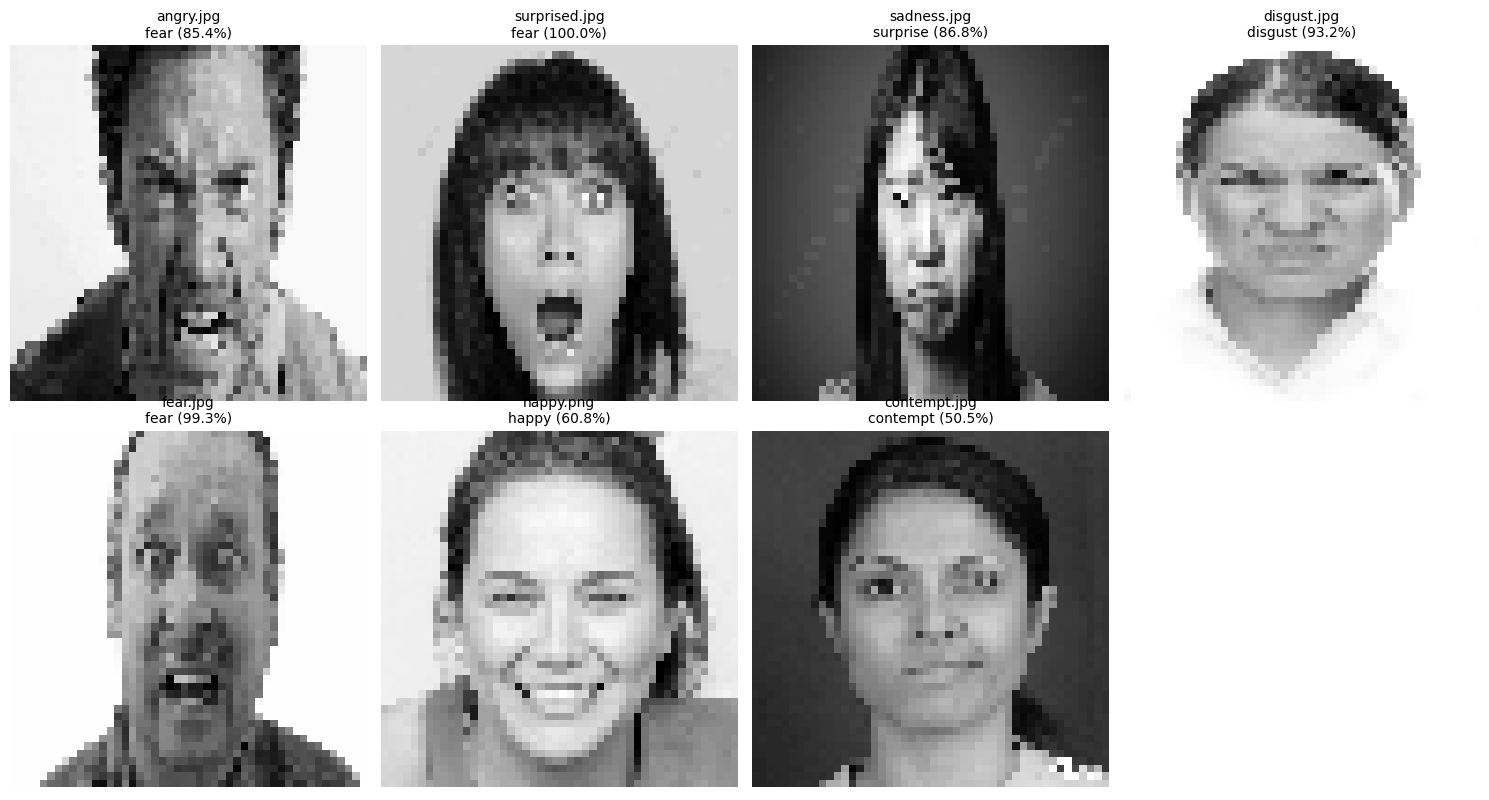


=== SELESAI ===
Proses klasifikasi ekspresi wajah untuk semua gambar telah selesai!


In [ ]:
# Langkah 5: Visualisasi hasil (opsional)
print(f"\n=== VISUALISASI HASIL ===")

def show_results_grid(results, max_images=12):
    """Menampilkan grid gambar dengan hasil prediksi"""
    if not results:
        print("Tidak ada hasil untuk ditampilkan")
        return

    # Batasi jumlah gambar yang ditampilkan
    display_results = results[:max_images]

    # Hitung jumlah baris dan kolom untuk grid
    n_images = len(display_results)
    cols = min(4, n_images)
    rows = (n_images + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(15, 4*rows))
    if rows == 1:
        axes = [axes] if cols == 1 else axes
    else:
        axes = axes.flatten()

    for i, res in enumerate(display_results):
        ax = axes[i] if rows > 1 or cols > 1 else axes

        # Tampilkan gambar
        img_array = res['result']['image_array']
        ax.imshow(img_array, cmap='gray')

        # Tambahkan judul dengan hasil prediksi
        filename = res['filename']
        dominant_label = res['result']['dominant_label']
        dominant_prob = res['result']['dominant_prob']

        title = f"{filename}\n{dominant_label} ({dominant_prob*100:.1f}%)"
        ax.set_title(title, fontsize=10)
        ax.axis('off')

    # Sembunyikan sumbu yang tidak digunakan
    for i in range(n_images, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Tampilkan visualisasi jika ada hasil
if results:
    show_results_grid(results)

    if len(results) > 12:
        print(f"Menampilkan 12 gambar pertama dari {len(results)} total gambar")
else:
    print("Tidak ada hasil untuk divisualisasikan")

print("\n=== SELESAI ===")
print("Proses klasifikasi ekspresi wajah untuk semua gambar telah selesai!")